# Analysing the "Adverse Weather Scenarios for Future Electricity Systems" dataset, as part of the CIReN project.

## Petros Zantis
## May - July 2023

<font size="4">

* In this notebook, the user can select many events within the dataset which fall under the desired classification *(extremity, global warming level etc.)*
    
    
* The chosen events are then compared via the use of **Box plots**, which are a nice way to summarise sets of data. The wind speeds and surface temperatures are averaged over the Polish wind farms, to highlight the effect over Poland. 
    
    * This was chosen since we run our power flow (cascade) simulations on the *case2736sp* MATPOWER model, which represents the Polish power network at the summer of 2004
    * The user can specify any other set of locations as a dictionary (see the Polish_Wind_Farms one) and basically repeat the same data analysis
    
    
* Time series for **surface temperature**, **wind speed** and **converted power generation** are then plotted for each event. The worst wind drought and hottest days are indicated in the plots. In addition, a power generation histogram is shown, indicating the percentage of each bin of power generation over all Polish wind farms *(for example, notice how the first bin is always the largest, which corresponds to the least wind power generation!)*
</font>


In [1]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt
from myClasses import *

from netCDF4 import Dataset
from IPython.display import HTML
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["font.size"] = 15

%matplotlib inline

In [2]:
'''Data repository from CEDA'''

#dataset_loc = '.\\dap.ceda.ac.uk\\badc\\deposited2021\\adverse_met_scenarios_electricity\\data\\long_duration'

''' *** Change this string to your local dataset folder location *** '''

dataset_loc = 'C:\\Users\\pz61\\Box\\CIReN_Shared\\Task 2a - climate impacts\\Data'

# Details of the event of interest
event_type = [ 'summer_wind_drought', 'winter_wind_drought', 'summer_surplus_generation', '*']
location = ['europe', 'uk']
extremity = ['return_period_1_in_2_years', 'return_period_1_in_5_years', 'return_period_1_in_10_years', 
 'return_period_1_in_20_years', 'return_period_1_in_50_years', 'return_period_1_in_100_years' , 'most_extreme_events', '*']
duration_severity = ['duration' , 'severity', '*']
global_warming_level = ['gwl4degC', 'gwl3degC', 'gwl2degC', 'gwl12-4degC', 'gwl12-2degC', '*']
event_no = ['*', 'event1', 'event2', 'event3']

def select_events(event_type, location, extremity, duration_severity, global_warming_level, event_no):
    '''A function to interactively select the event of interest from the complete database'''
    
    file_str = dataset_loc
    if extremity == 'most_extreme_events' : global_warming_level =''
    details = [event_type, location, extremity, duration_severity, global_warming_level, event_no]
    for det in details:
        file_str = os.path.join(file_str, det).replace(os.sep, '\\')
    print("\nThe selected events are: {}".format(file_str))
    return os.path.join(file_str, '*.nc').replace(os.sep, '\\')

interactive_plot = interactive(select_events, event_type=event_type, location=location, extremity=extremity, 
                              duration_severity=duration_severity, 
                               global_warming_level=global_warming_level, event_no=event_no )
interactive_plot

interactive(children=(Dropdown(description='event_type', options=('summer_wind_drought', 'winter_wind_drought'…

In [17]:
file_str = interactive_plot.result

print(file_str)

C:\Users\pz61\Box\CIReN_Shared\Task 2a - climate impacts\Data\summer_wind_drought\europe\return_period_1_in_50_years\severity\*\event1\*.nc


In [18]:
def create_events(file_str):
    '''A function to create Event instances for the imported events and add them in the Event_list 

        file_str (str) : the desired event file location
    '''
    
    print("Creating events:")
    Event_list = []
    try:
        filelist = glob.glob(file_str)
        
        for file in filelist:
            details = file.split('\\')[7:-1]               

            if len(Event_list)==0 or [*Event_list[-1].get_event_details().values()] != details:
                print(*details)
                Event_list.append(Event(*details))
            else:
                print("Not added again, it's the same event!")
                
    except IndexError as i: # or FileNotFoundError as f: 
        print(str(i))
        print("The file you asked for does not exist. Try checking the directory.")
        
    if len(Event_list)==0:
        print('No events match the requirements - try different parameters.')
               
    return Event_list
        
Events_list = create_events(file_str)

Creating events:
summer_wind_drought europe return_period_1_in_50_years severity gwl12degC event1
Not added again, it's the same event!
Not added again, it's the same event!
summer_wind_drought europe return_period_1_in_50_years severity gwl15degC event1
Not added again, it's the same event!
Not added again, it's the same event!
summer_wind_drought europe return_period_1_in_50_years severity gwl2degC event1
Not added again, it's the same event!
Not added again, it's the same event!
summer_wind_drought europe return_period_1_in_50_years severity gwl3degC event1
Not added again, it's the same event!
Not added again, it's the same event!
summer_wind_drought europe return_period_1_in_50_years severity gwl4degC event1
Not added again, it's the same event!
Not added again, it's the same event!


In [19]:
def open_files(event_list, print_checks = False):
    '''A function to open the datasets from the .nc files and extract the quantities of interest, 
        and creates WeatherVariable instances to store the data and their details

        event_list (list of Events) : the list of Event instances created with create_events()
        print_checks (Bool) : a boolean to set if detailed checks are to be printed
    '''
        
    for event in event_list:
        details = event.get_event_details()
        file_str = dataset_loc
        for det in details:
            file_str = os.path.join(file_str, details[det]).replace(os.sep, '\\')
        file_str = os.path.join(file_str, '*.nc').replace(os.sep, '\\')
        
        try:
            filelist = glob.glob(file_str)
            data_lists = {}
            
            for file in filelist:
                
                dataset = Dataset(file ,mode='r')          
                var_str = list(dataset.variables.keys())[-1]

                lons = dataset.variables['longitude'][:]
                lats = dataset.variables['latitude'][:]
                gridded_lons, gridded_lats = np.meshgrid(lons,lats)

                time = dataset.variables['time'][:]
                variable = dataset.variables[var_str][:]  # data in shape [time,lat,lon]

                dataset.close()
                
                data_lists[var_str] = gridded_lons, gridded_lats, lons, lats, variable, time
                
                if print_checks:
                    # see the file inputs and netcdf dictionary keys to load:
                    print(file)
                    print("\nThe chosen file contains: {}".format(dataset.variables.keys()))
                    print("Longitude array shape: {}".format(lons.shape))
                    print("Latitude array shape: {}".format(lats.shape))
                    print("Time array shape: {}".format(time.shape))
                    print("Complete {} array shape: {}".format(var_str, variable.shape))

                    print("Minimum {} in data: {}".format(var_str, variable.min()))
                    print("Maximum {} in data: {}".format(var_str, variable.max()))
                    print()
                
            Wind = WeatherVariable('wind_speed', '100m Wind Speed', '(ms$^{-1}$)', plt.cm.RdBu_r, 'royalblue' )
            Temp = WeatherVariable('t2m', 'Surface Temperature', '($^{o}C$)', plt.cm.RdYlBu_r, 'darkorange' )
            Ssr = WeatherVariable('ssr', 'Net Surface Solar Radiation', '(W$s^{-2}$)', plt.cm.viridis, 'firebrick' )
            
            Wind.set_data(*data_lists[Wind.var])
            Temp.set_data(*data_lists[Temp.var])
            Temp.convert_to_C() 
            Ssr.set_data(*data_lists[Ssr.var])
            
            event.add_weather_variable(Wind)
            event.add_weather_variable(Temp)
            event.add_weather_variable(Ssr)
            
        except IndexError or FileNotFoundError: 
            print("The file you asked for does not exist. Try checking the directory.")
            
    if len(event_list)==0:
        print('No events match the requirements - try different parameters.')
        
open_files(Events_list)

In [20]:
def get_box_plot(boxes, clr, ax): 
    '''Box plot customisation'''

    boxprops = dict(color=clr)
    medianprops = dict(color=clr)
    whiskerprops = dict(color=clr)
    flierprops = dict(marker='X', markerfacecolor=clr, markeredgecolor='none')#, markersize=12)
    meanlineprops = dict(linestyle='--', color='green')

    bp = ax.boxplot(boxes, showmeans=True, meanline=True, meanprops=meanlineprops, 
                boxprops=boxprops, medianprops=medianprops, flierprops=flierprops, 
                whiskerprops=whiskerprops, capprops=whiskerprops) 


In [21]:
''' Dictionary details:
Name : (Latitude, Longitude, No of wind turbines)
Maybe later add the specific turbine specs as well...
'''

Polish_Wind_Farms = {'Zary' : (51.69 , 15.10, 150),
                     'Nowy' : (52.24 , 16.29, 150),
                     'Lubiewo' : (53.97 , 16.35, 150),
                     'Zarki' : (51.11 , 16.47, 150),
                     'Gasawa' : (53.39 , 17.30, 150),
                     'Grabina' : (50.51 , 17.62, 150),
                     'Zarnowiec' : (53.08 , 18.52, 150),
                     'Suszec' : (50.35 , 18.78, 150),
                     'Laziska' : (50.13 , 19.71, 150),
                     'Paslek' : (53.80 , 19.93, 150), 
                     'Mszczonow' : (52.09 , 20.69, 150), 
                     'Mstow' : (50.97 , 20.78, 150), 
                     'Zoludowo' : (52.69 , 22.10, 150)}

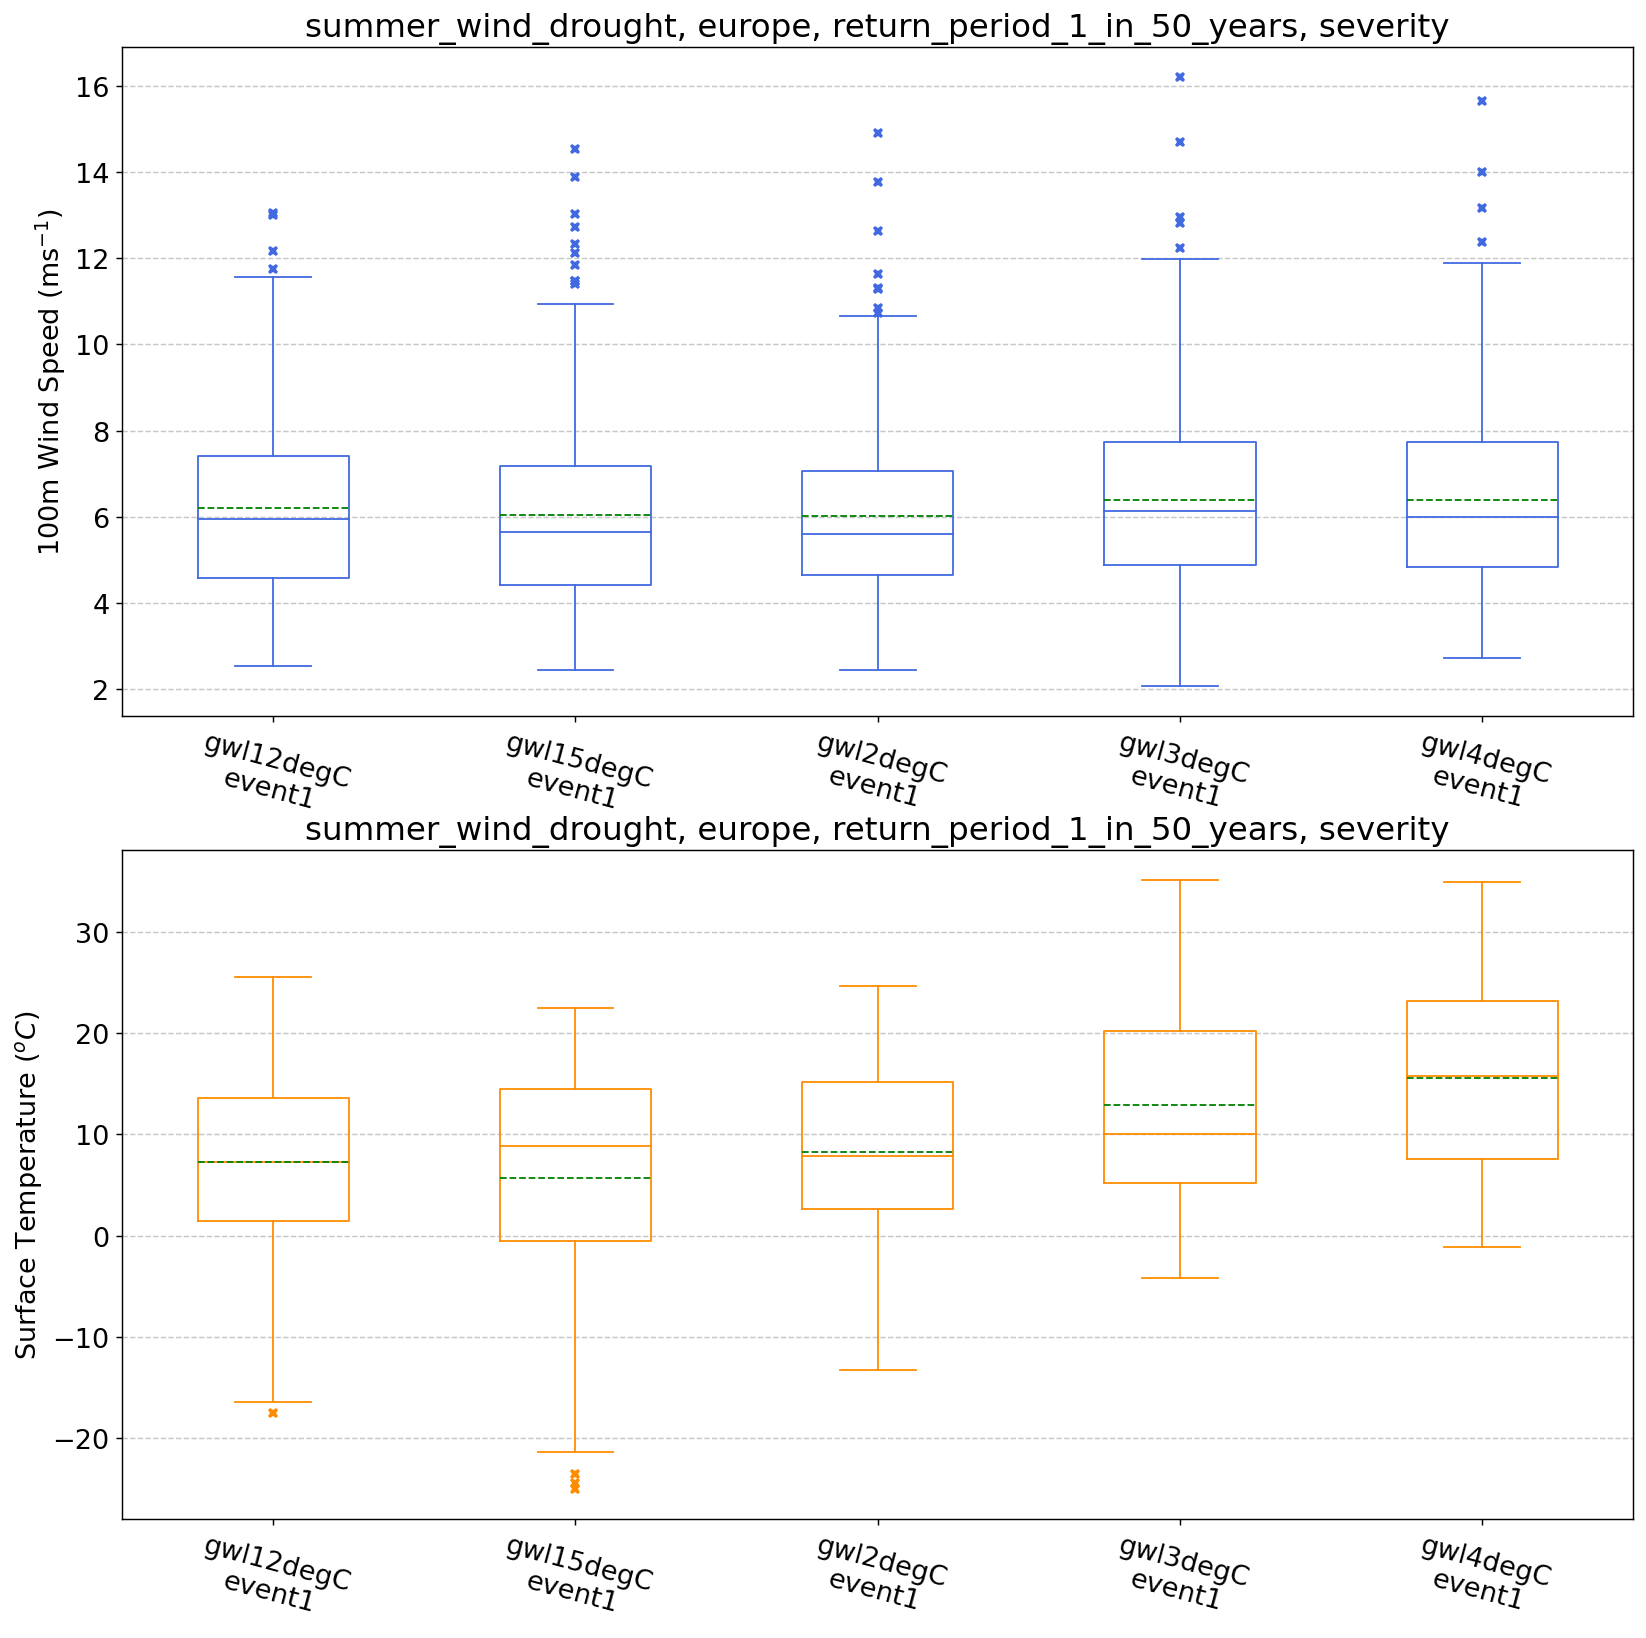

In [22]:

def compare_gwls(Polish_Wind_Farms):
    ''' The purpose of this function is to compare the different chosen events via the use of Box plots. 
    It only takes as argument the dictionary corresponding to the set of locations the user wishes to average over'''

    plt.rcParams["font.size"] = 15
    fig, ax = plt.subplots(2,1,figsize=(15,15), facecolor='w', dpi=130)

    all_boxes = [[], [], []]

    xlabels, ylabels, clrs = [],[],[] 

    for event in Events_list:
        title = event.get_event_details()
        #print([val for val in title.values()])
        #print(type(title.keys()))
        #xlabel = "{} \n {}".format(title["Global Warming Level"], title["Event no."])   # title["Extremity"],

        xlabel = "{}\n{}".format(title["Global Warming Level"], title["Event no."])
        xlabels.append(xlabel)

        for idx, weather_var in enumerate(event.weather_vars): 

            ylabel = weather_var.name +' '+ weather_var.units
            ylabels.append(ylabel)
            clrs.append(weather_var.clr)
            
            allfarms = []

            for wind_farm in Polish_Wind_Farms:
            
                lat,lon,turb_no = Polish_Wind_Farms[wind_farm]
                lat_idx, lon_idx, lat, lon = weather_var.find_location(lat, lon, printLoc=False)
                allfarms.append(weather_var.var_data[:,lat_idx, lon_idx].flatten())
            
            all_boxes[idx].append(np.array(allfarms).mean(axis=0))
            
    for i, boxes in enumerate(all_boxes[0:2]):
        boxes = np.array(boxes, dtype=object)
        get_box_plot(boxes.T, clrs[i], ax=ax[i])
        ax[i].set_ylabel(ylabels[i]) 
        ax[i].grid(axis='y',linestyle='--',alpha=0.7)
        ax[i].set_xticklabels(xlabels, rotation=-15)
        ax[i].set_title("{}, {}, {}, {}".format(title["Event type"], title["Location"], 
                                            title["Extremity"], title["Duration/Severity"]))

    plt.show()

    
#Polish_Wind_Farms = {'Mstow' : (50.97 , 20.78, 50)}   ## for testing on a single farm
compare_gwls(Polish_Wind_Farms)

### The box plots above compare the wind speeds and surface temperatures of the different events. For example, a clear increasing trend in average temperature is seen if global warming levels are chosen, in addition to increasing wind speed extremities
### The function below compares the power generated in the different events, and plots the corresponding time series and histograms

['summer_wind_drought', 'europe', 'return_period_1_in_50_years', 'severity', 'gwl12degC', 'event1']


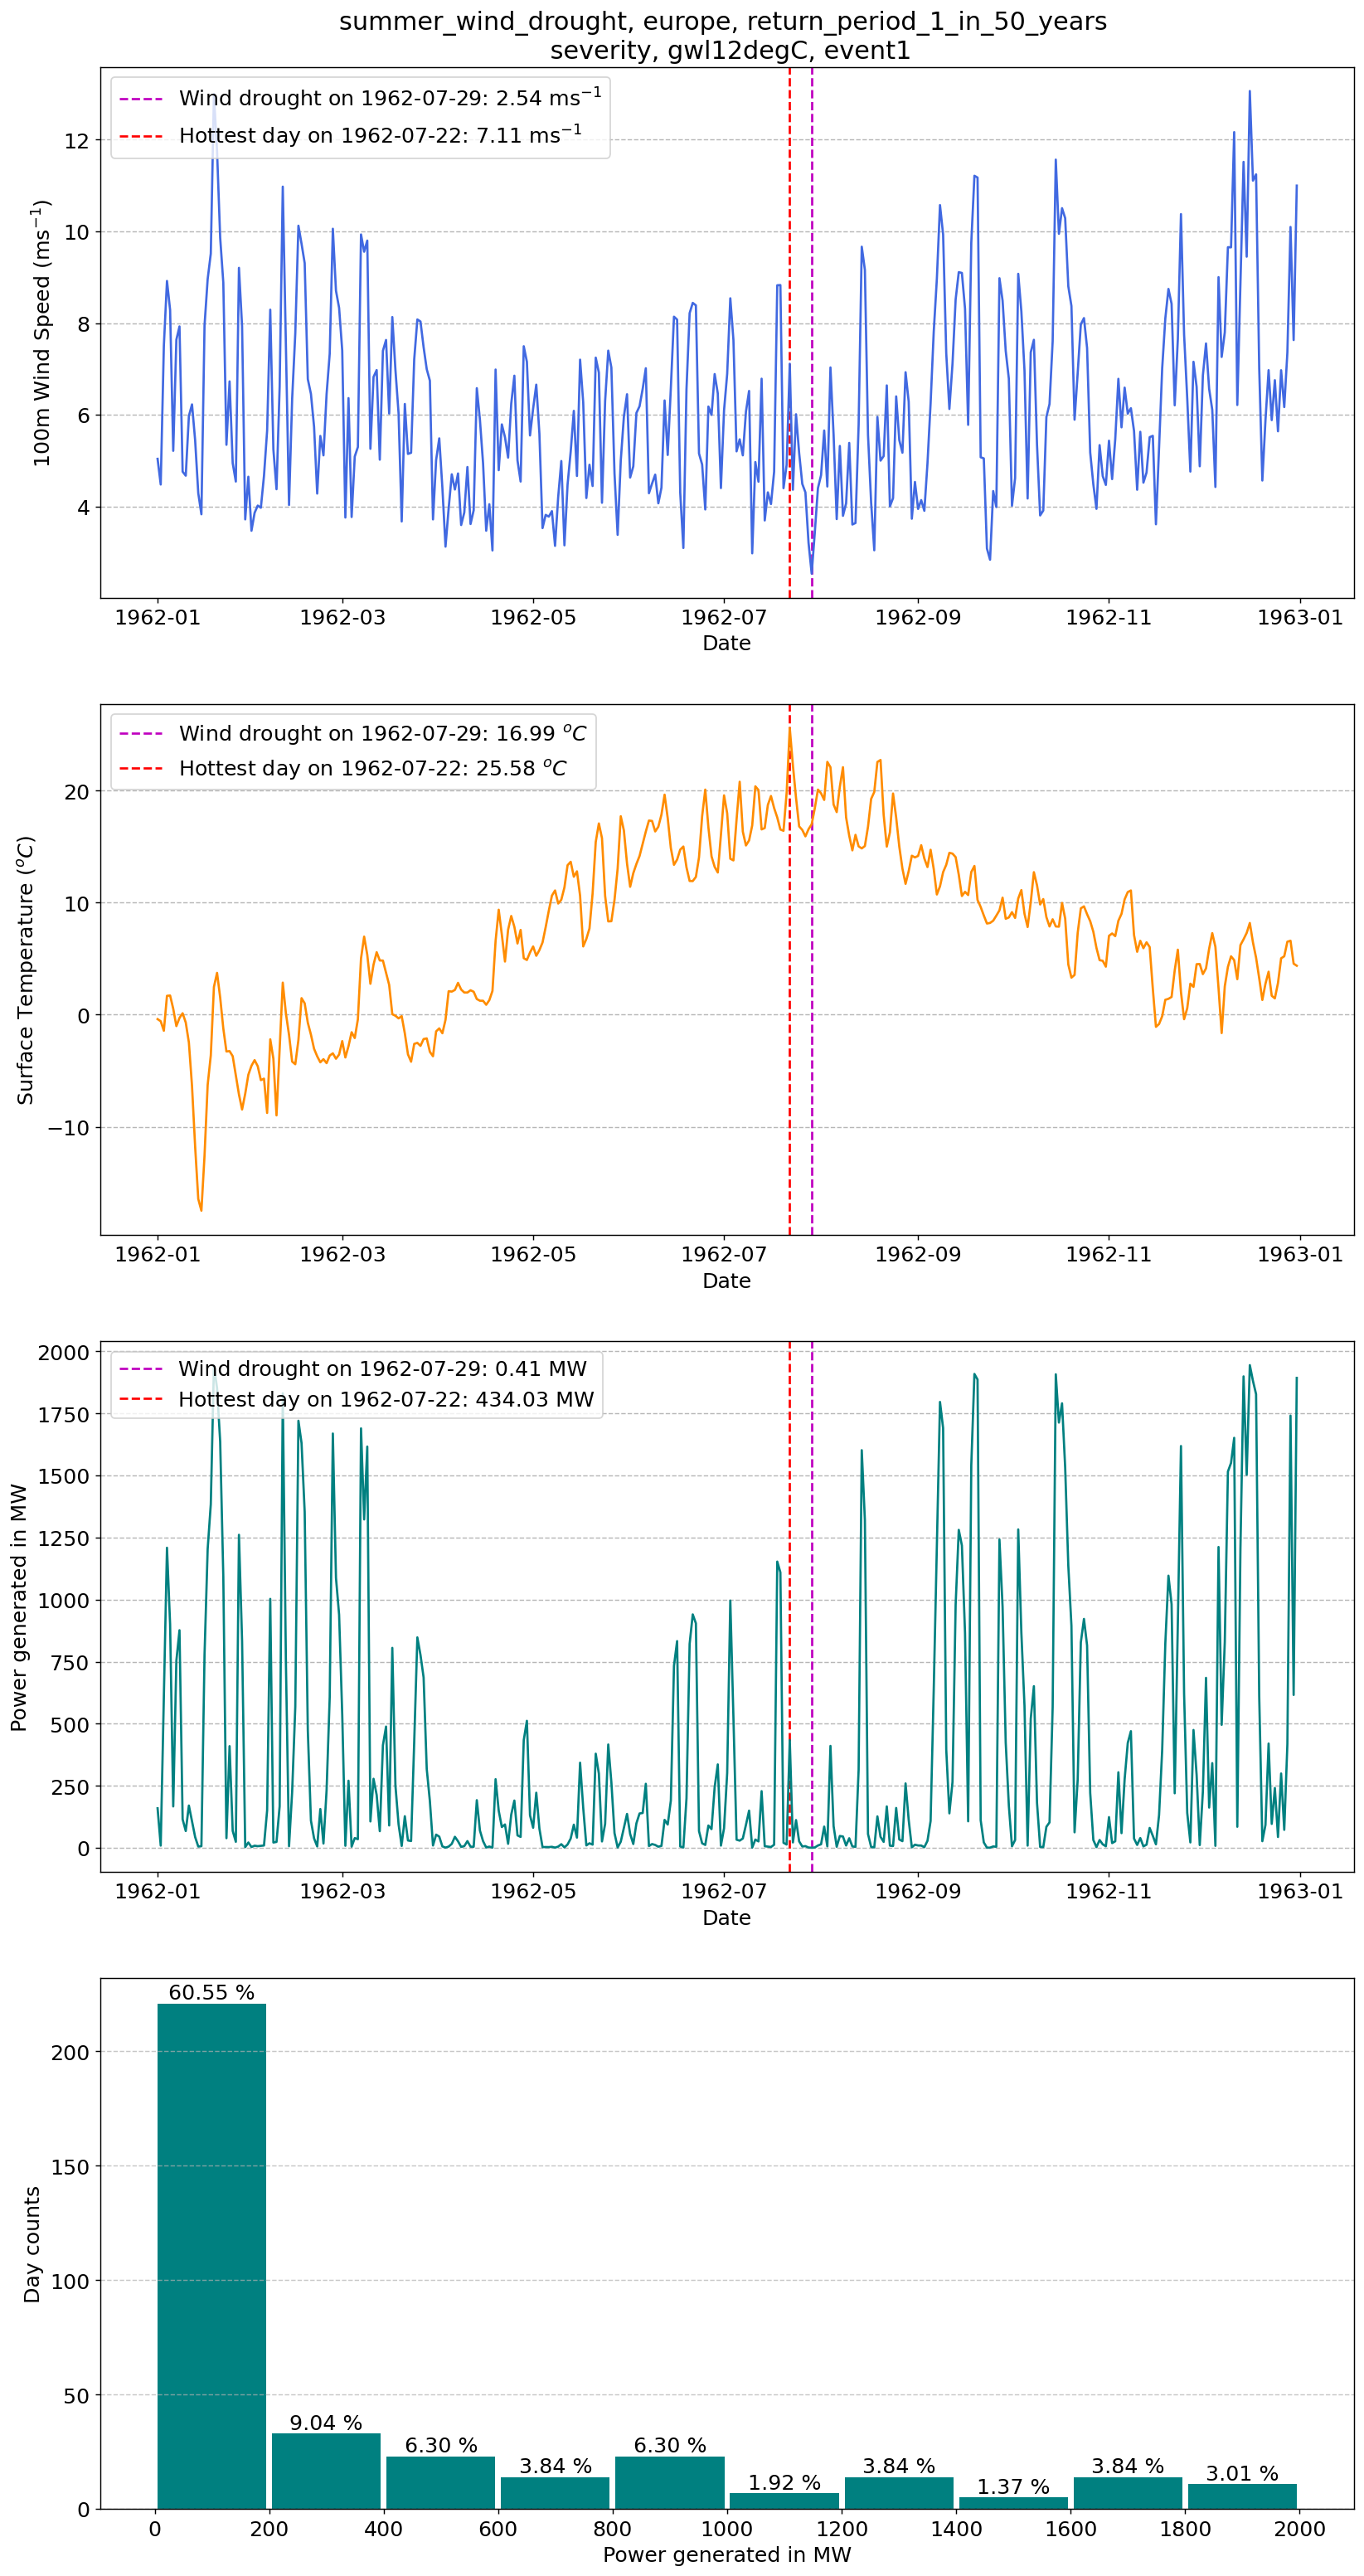

['summer_wind_drought', 'europe', 'return_period_1_in_50_years', 'severity', 'gwl15degC', 'event1']


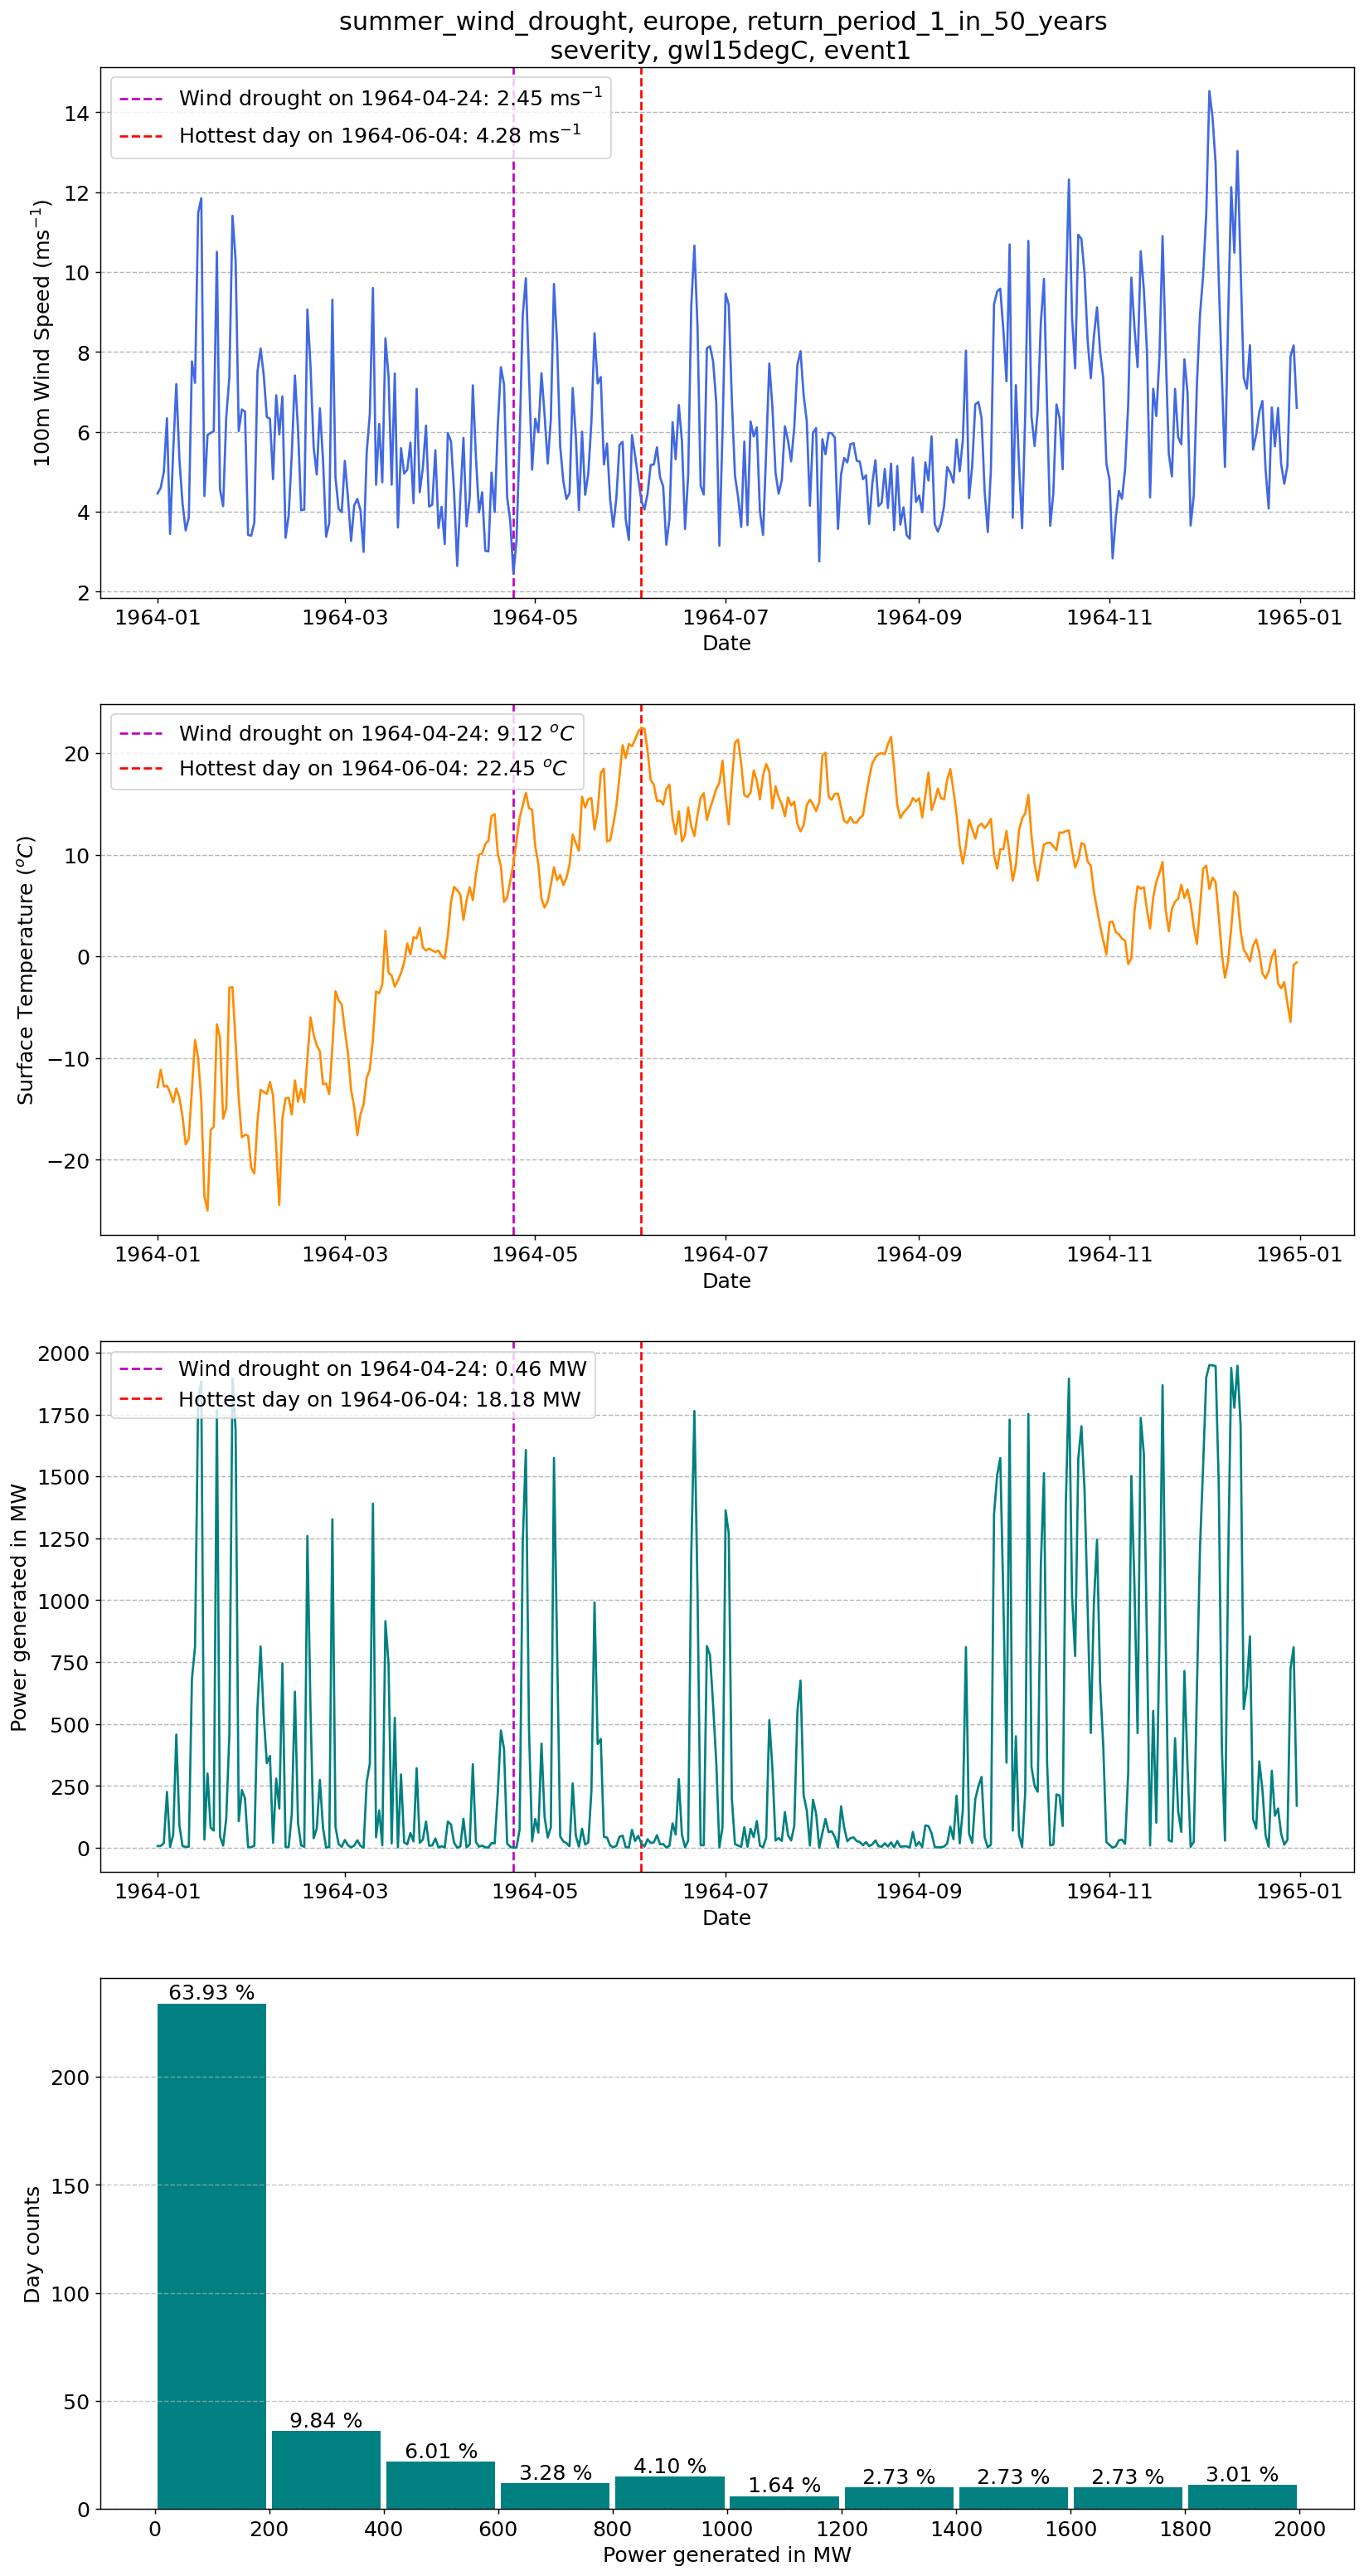

['summer_wind_drought', 'europe', 'return_period_1_in_50_years', 'severity', 'gwl2degC', 'event1']


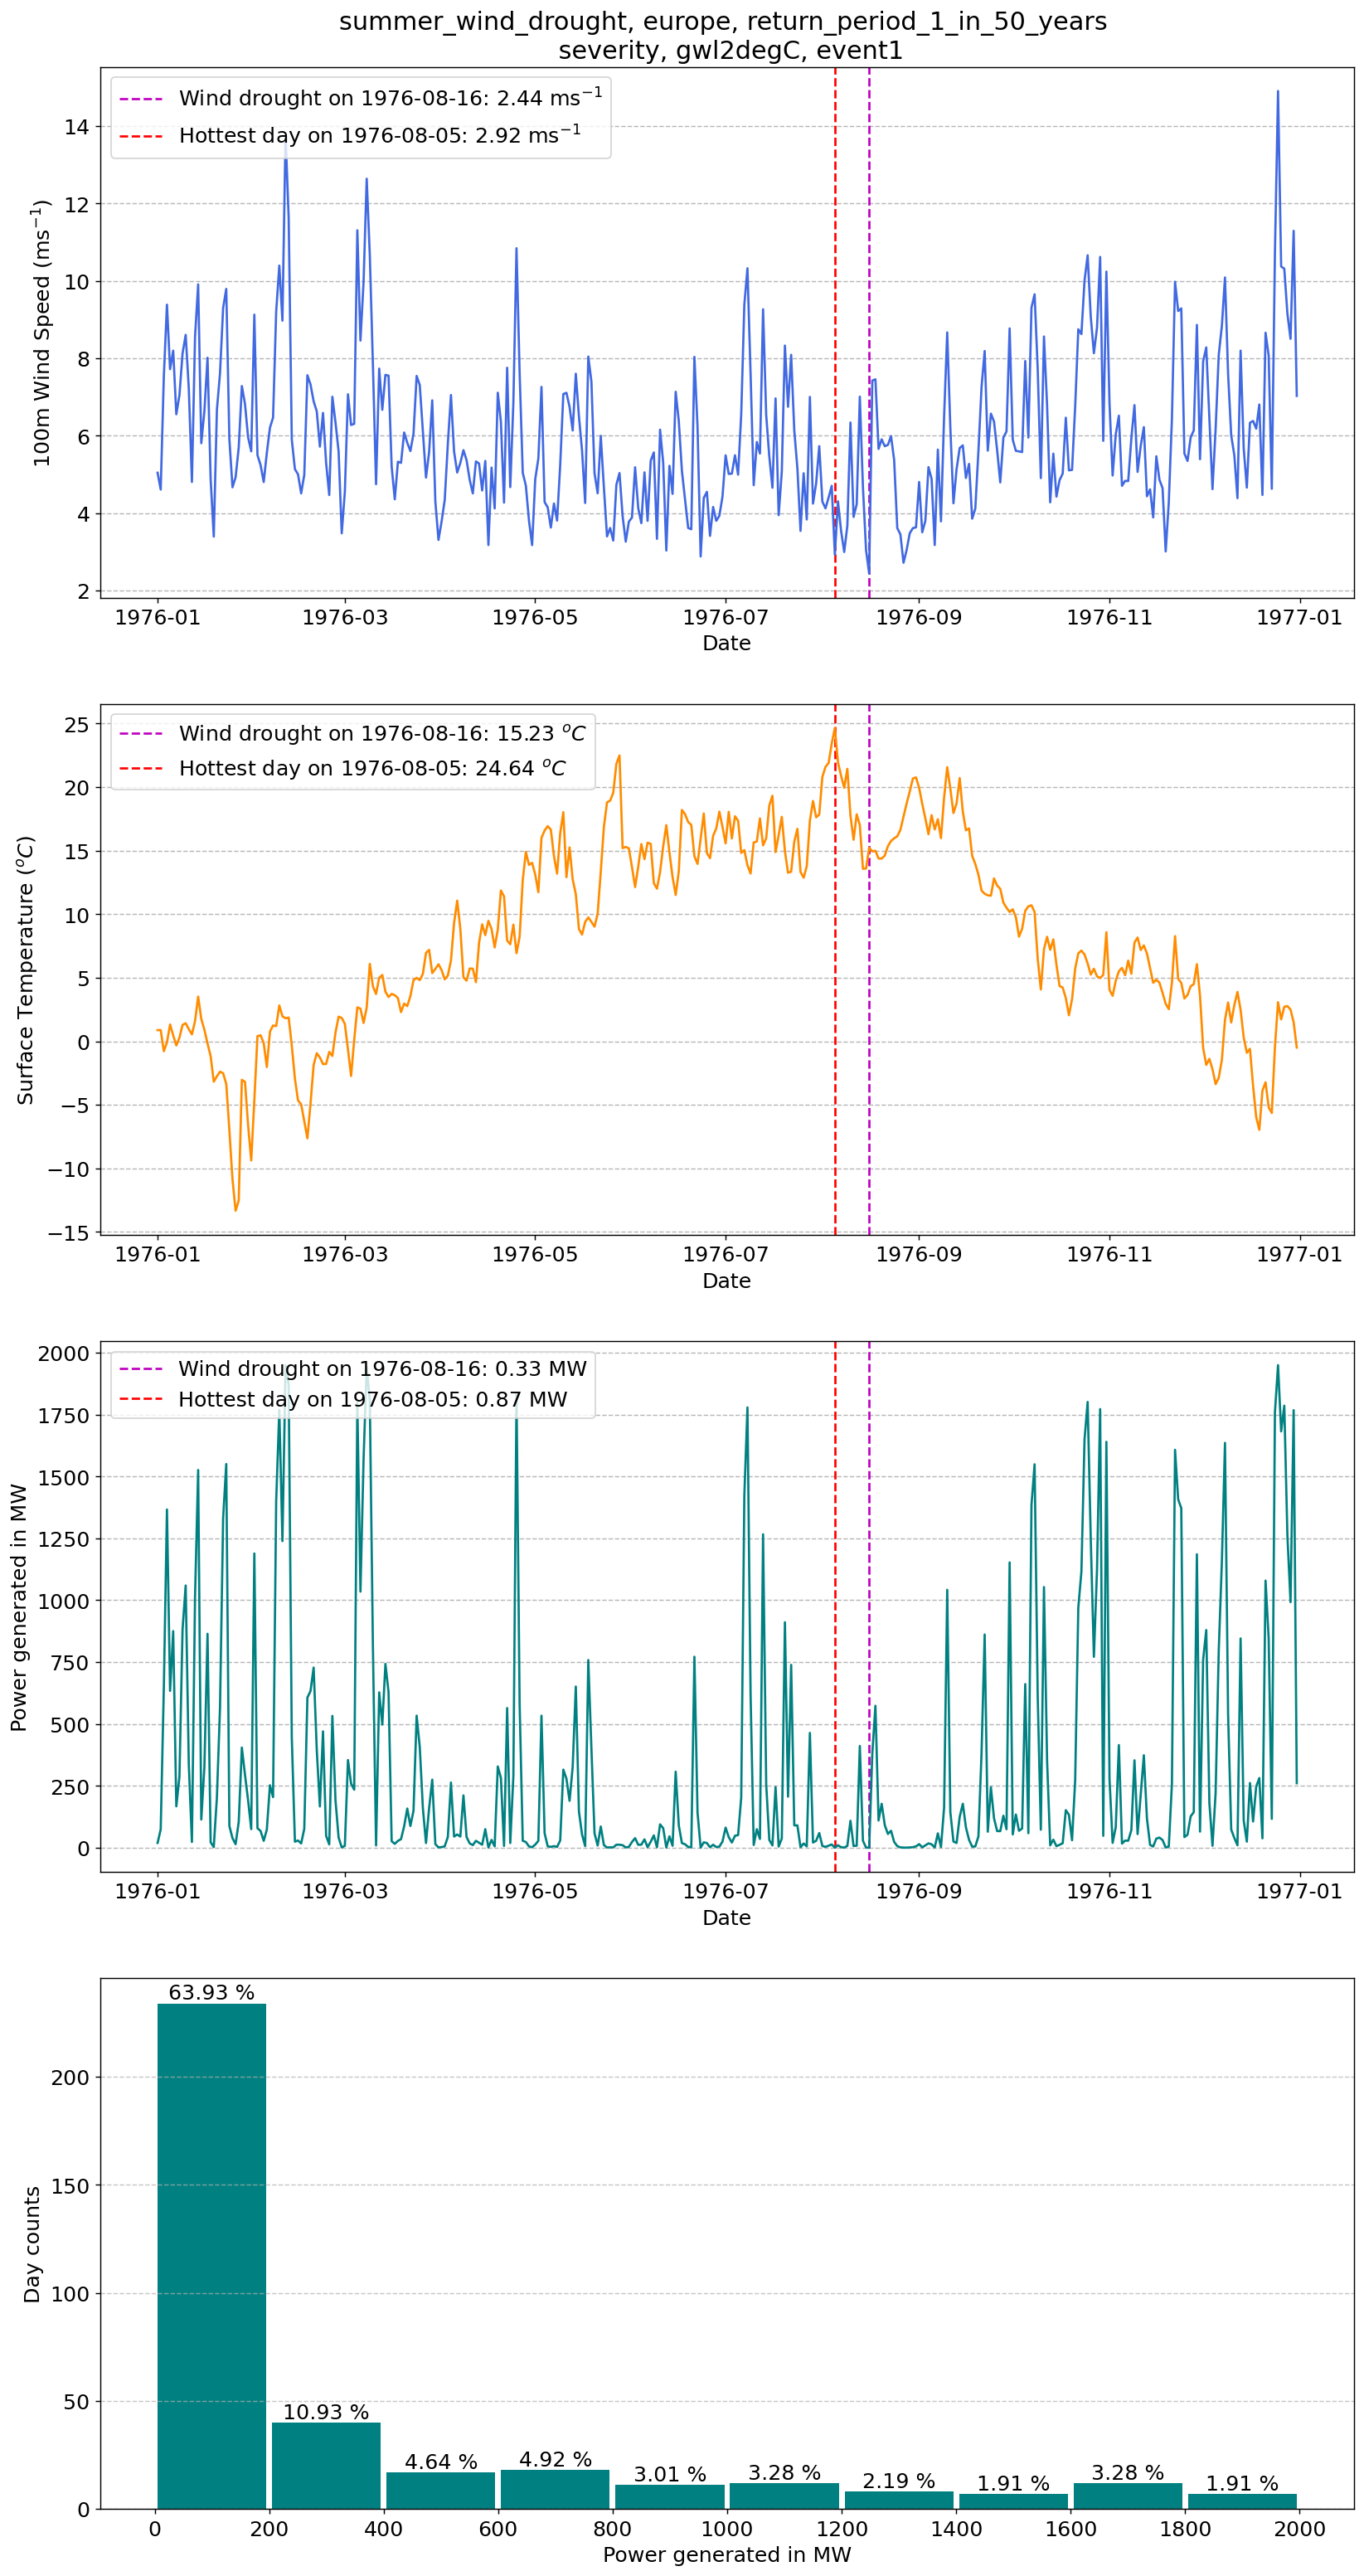

['summer_wind_drought', 'europe', 'return_period_1_in_50_years', 'severity', 'gwl3degC', 'event1']


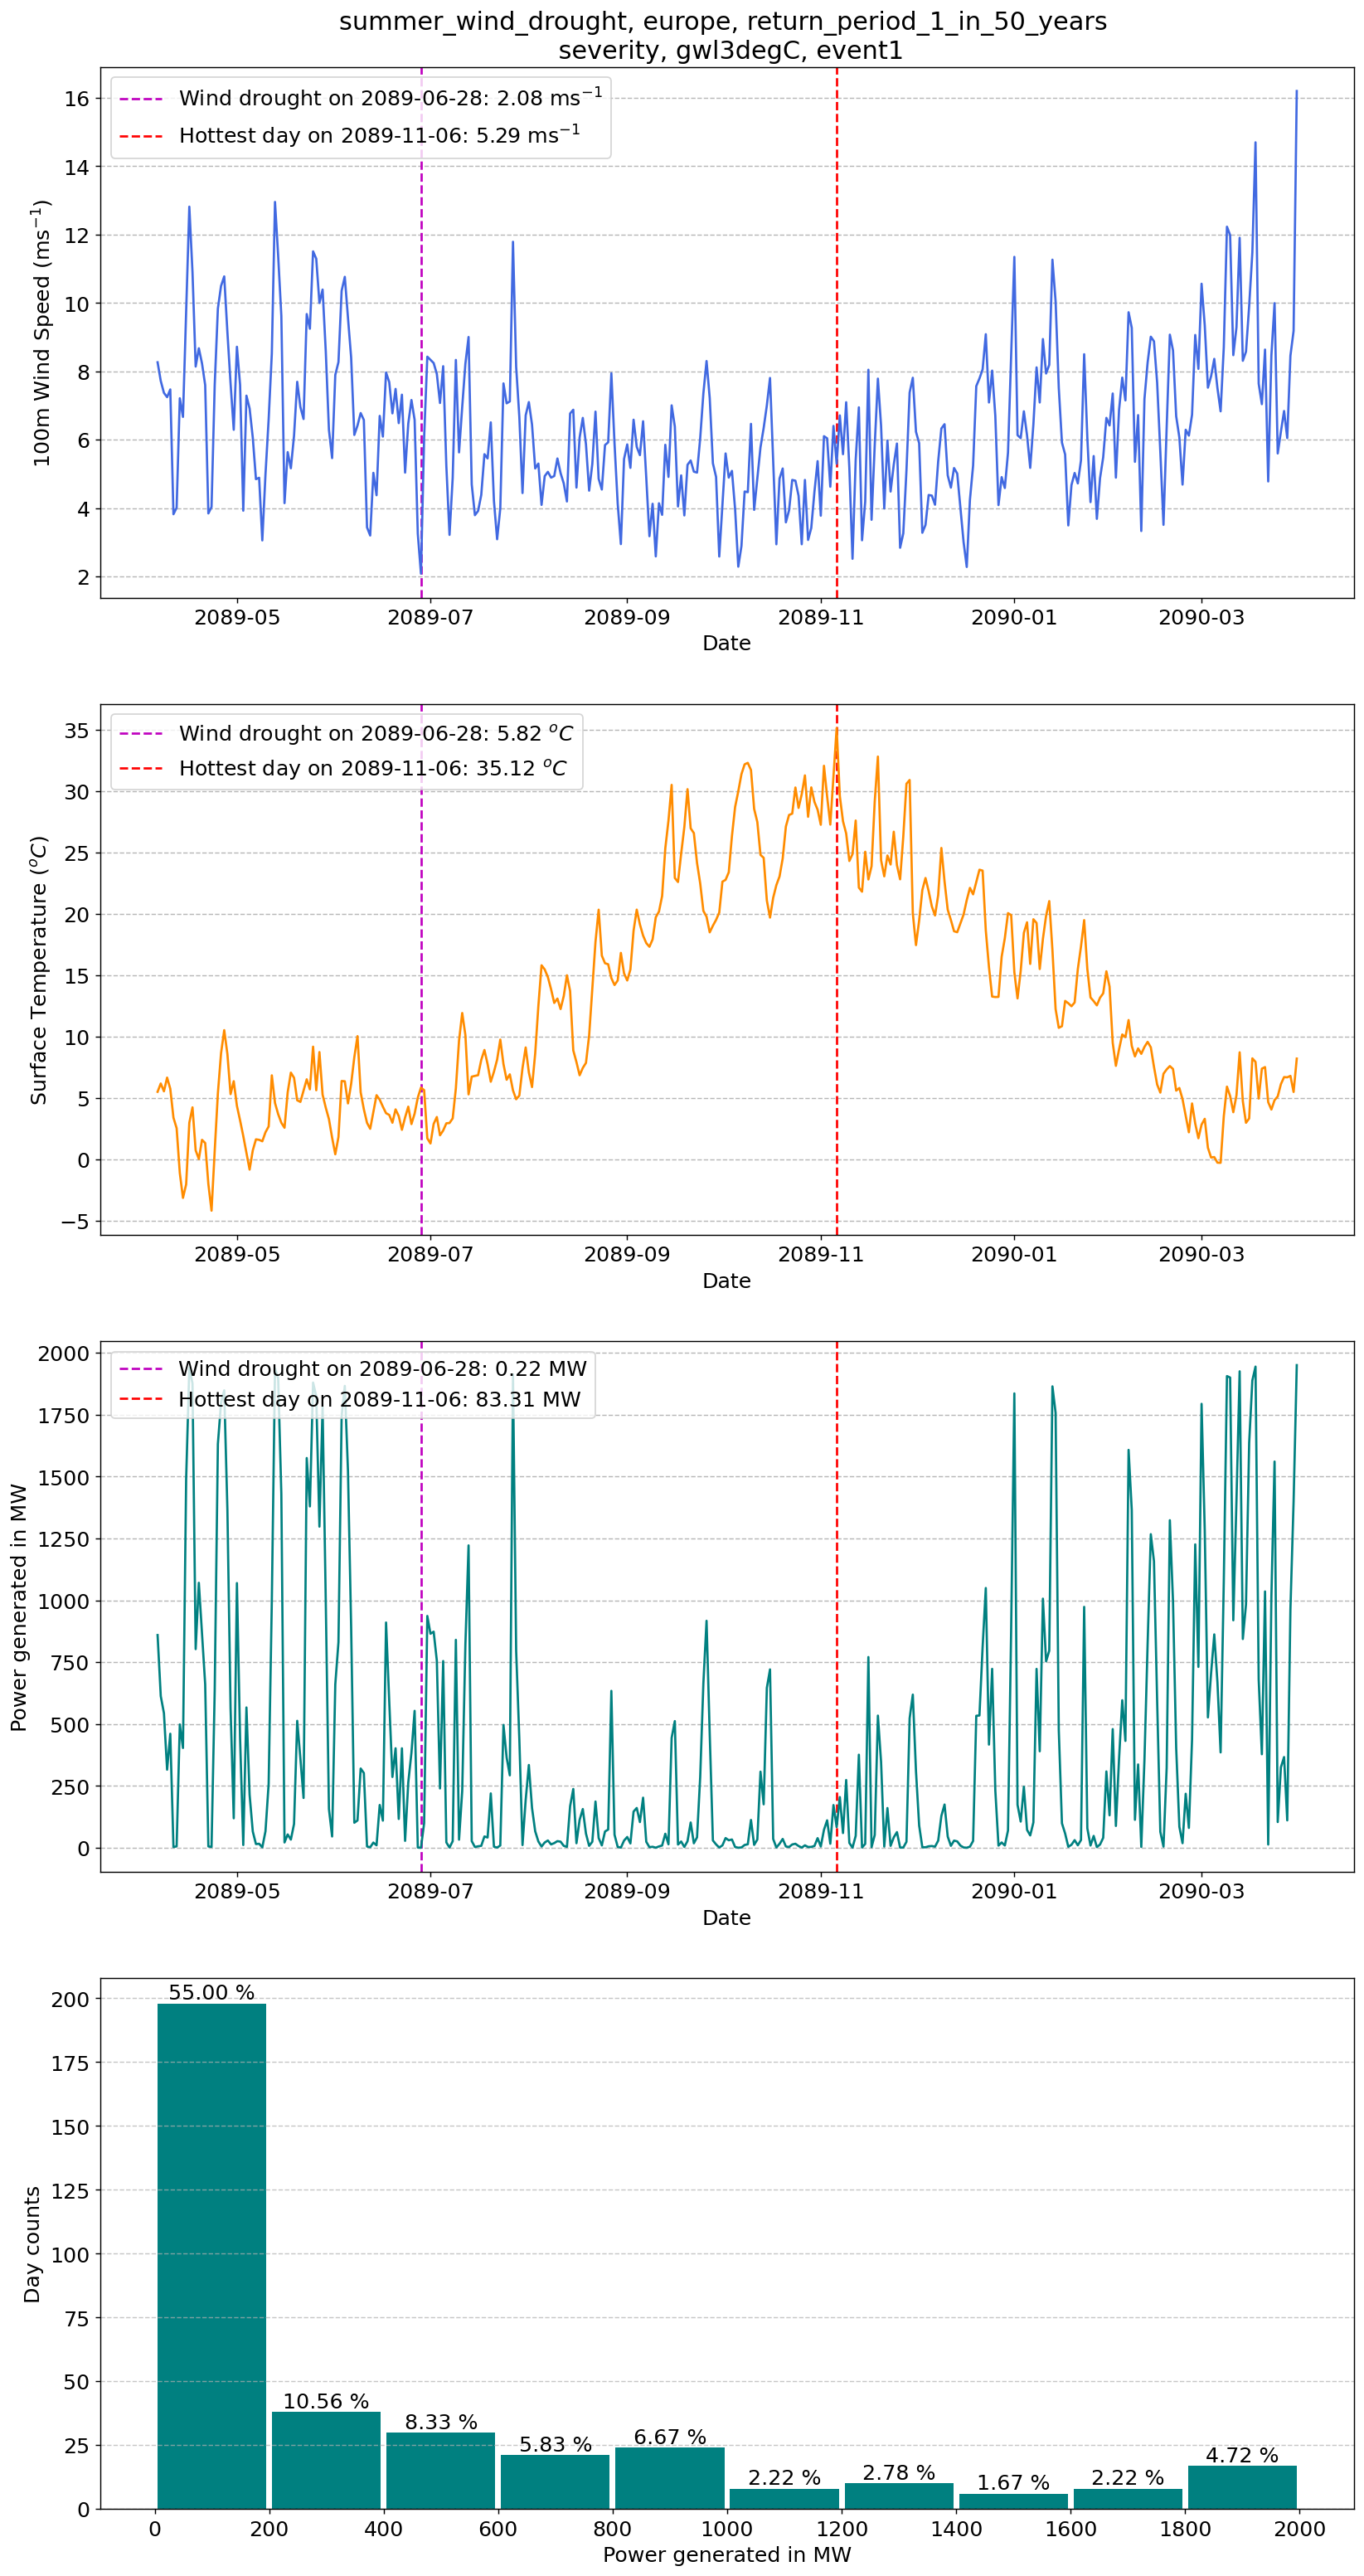

['summer_wind_drought', 'europe', 'return_period_1_in_50_years', 'severity', 'gwl4degC', 'event1']


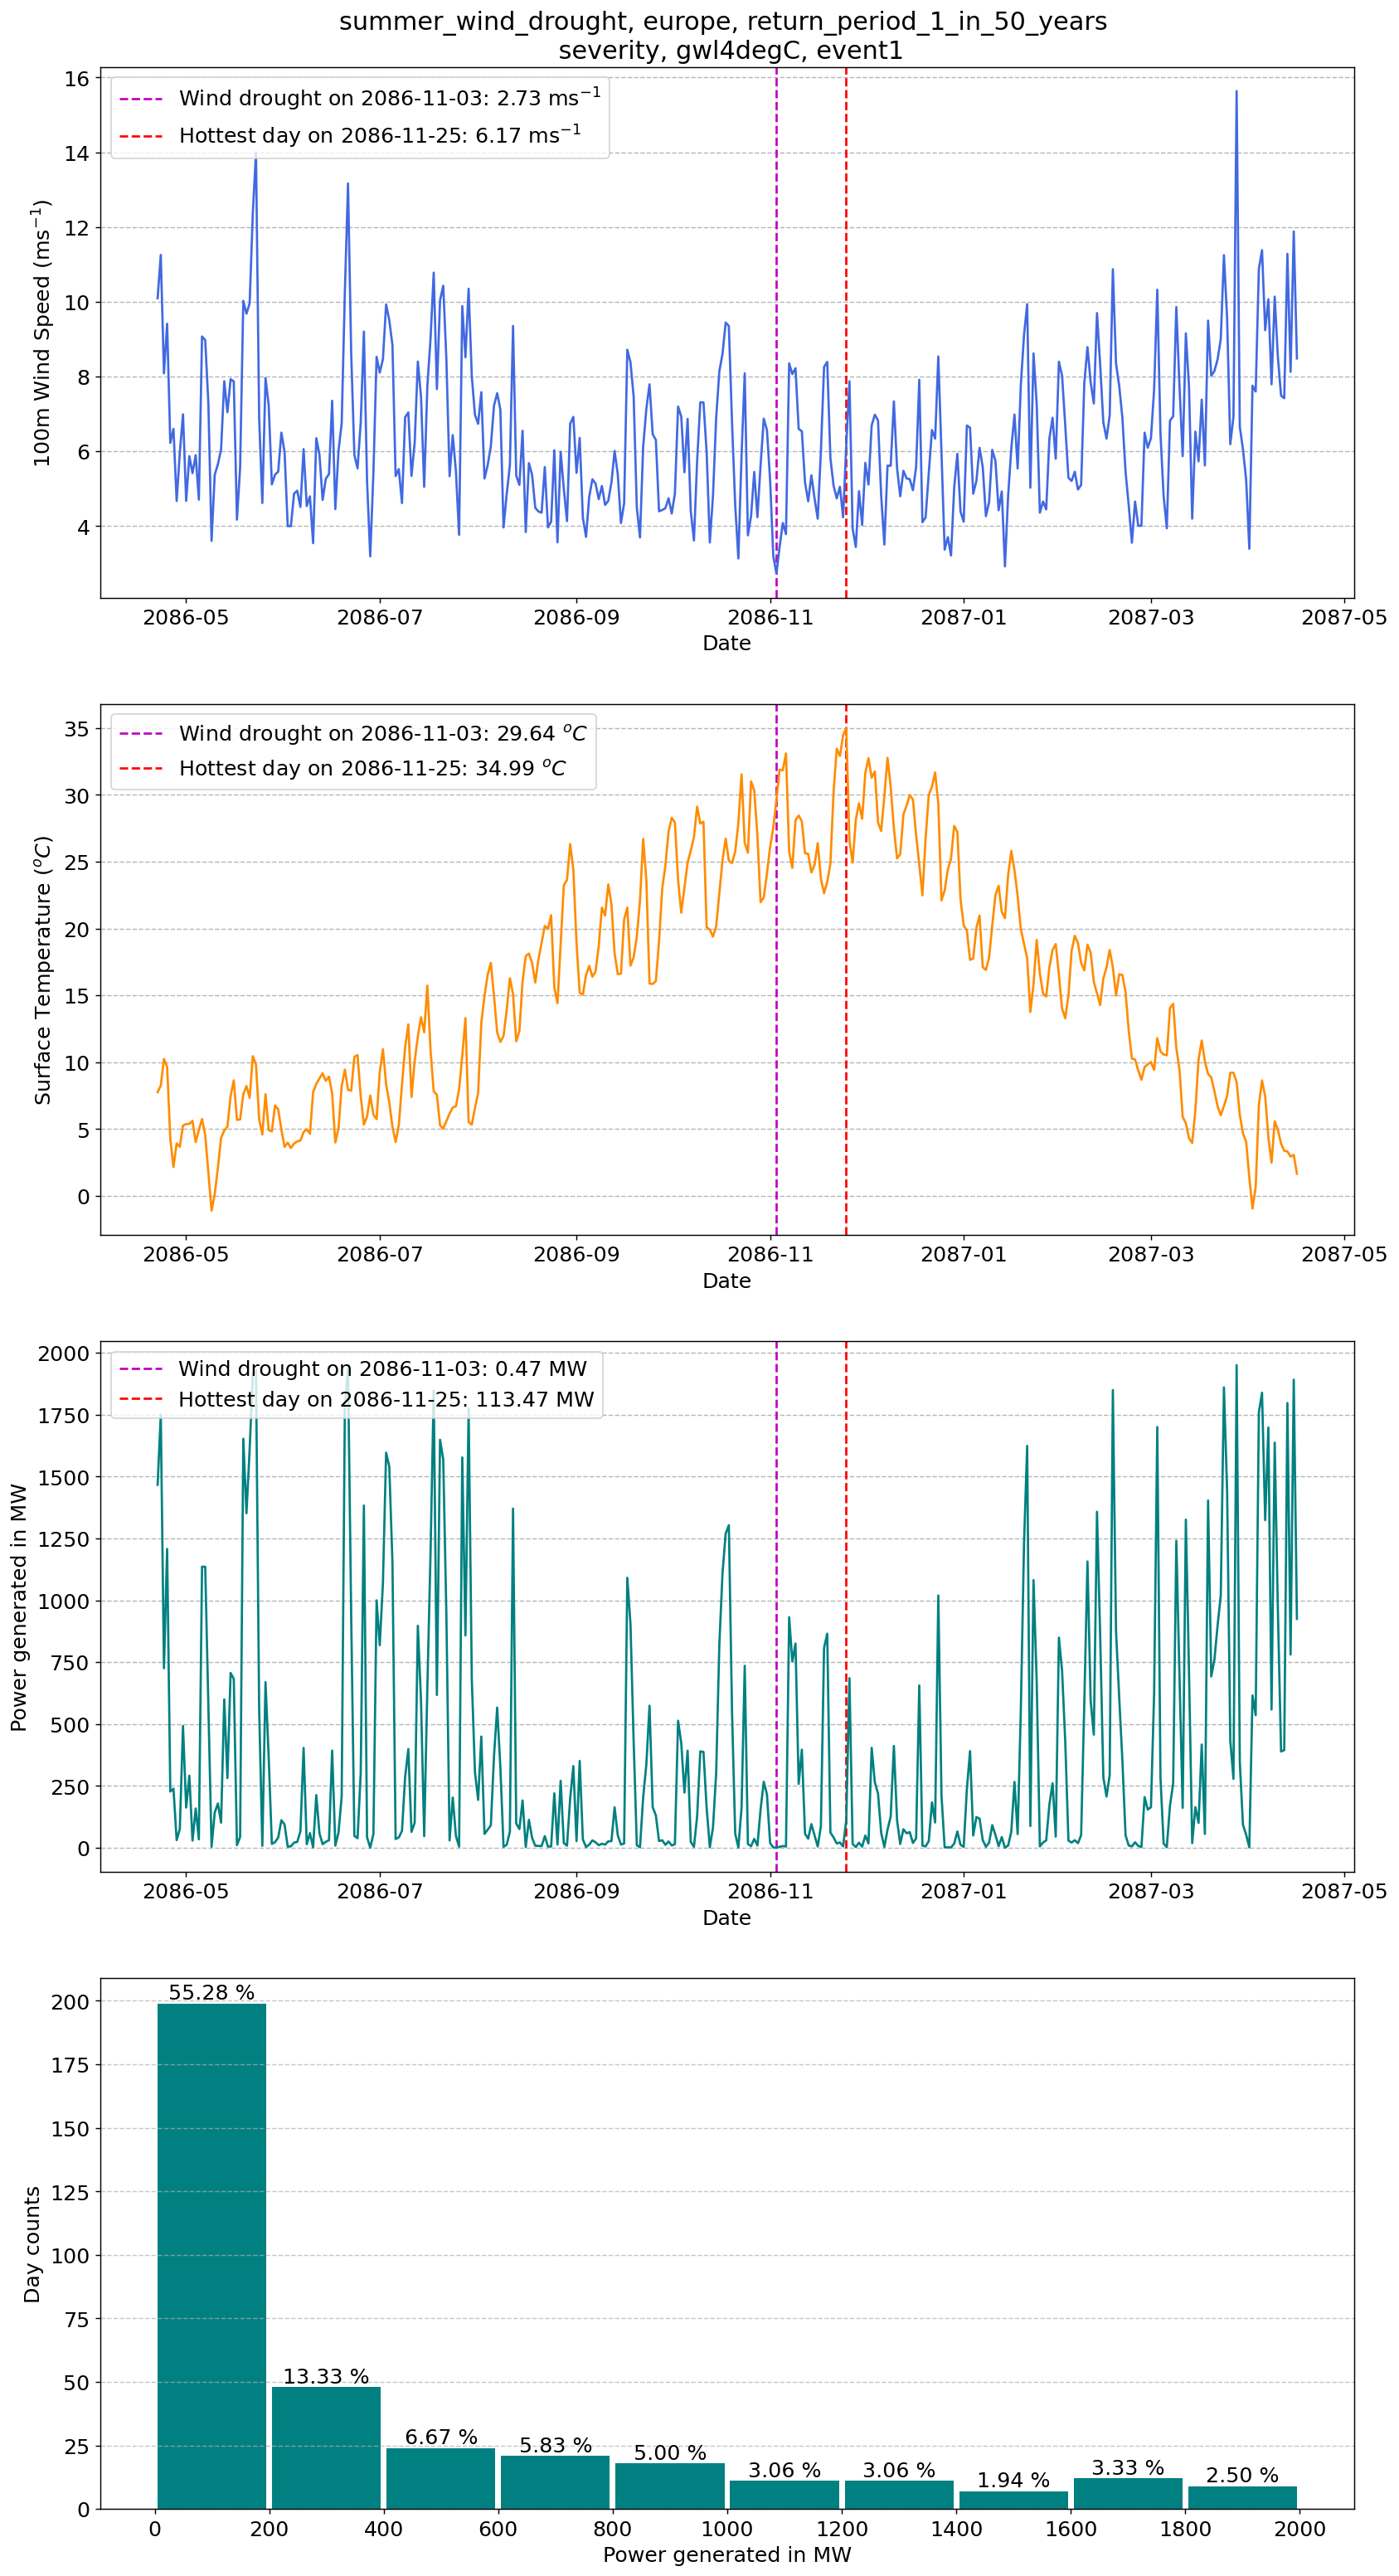

In [23]:
def compare_events_powers(Polish_Wind_Farms):

    plt.rcParams["font.size"] = 14

    for event in Events_list:
        title = event.get_event_details()
        print([val for val in title.values()])  # to identify which event

        all_snap_data = [[], [], []]
        wind_powers = []
        xlabels, ylabels, units, clrs = [],[],[],[] 

        fig, ax = plt.subplots(4,1,figsize=(15,30), facecolor='w', dpi=130)

        for idx, weather_var in enumerate(event.weather_vars): 

            ylabel = weather_var.name +' '+ weather_var.units
            ylabels.append(ylabel)
            units.append(weather_var.units[1:-1])
            clrs.append(weather_var.clr)

            for wind_farm in Polish_Wind_Farms:

                lat,lon,turb_no = Polish_Wind_Farms[wind_farm]                 
                date_conv, var_data, lat, lon = weather_var.get_var_time_data(lat, lon, printLoc=False)
                all_snap_data[idx].append(var_data.flatten())

                if weather_var.var=='wind_speed':  # for wind only
                    wind_powers.append(turb_no * WindTurbine().wind_power(var_data.flatten()))  # convert to power


        # quick way to add power labels before ssr labels
        ylabels.insert(2, 'Power generated in MW') 
        clrs.insert(2, 'teal')
        units.insert(2, 'MW')

        wind_powers = (np.array(wind_powers).sum(axis=0))/1e6  # wind power sum across Polish Wind farms, in MW
        drought = np.min(wind_powers)
        drought_idx = np.where(wind_powers==drought)[0][0]
        drought_date = date_conv[drought_idx]

        avg_temps = np.array(all_snap_data[1]).mean(axis=0)
        hottest = np.max(avg_temps)
        hottest_idx = np.where(avg_temps==hottest)[0][0]
        hottest_day = date_conv[hottest_idx]

        for i, snap_data in enumerate(all_snap_data[0:2] + [wind_powers]):

            snap_data = np.array(snap_data)
            if i==0 : allfarms = snap_data.mean(axis=0)     # average wind speed across Polish Wind farms
            elif i==1 : allfarms = snap_data.mean(axis=0)   # average surface temp across Polish Wind farms
            elif i==2 : allfarms = snap_data          # wind power sum across Polish Wind farms, in MW

            ax[i].axvline(drought_date, c='m', linestyle='dashed', label='Wind drought on {}: {:.2f} {}'.format(
                drought_date, allfarms[drought_idx], units[i]))
            ax[i].axvline(hottest_day, c='r', linestyle='dashed', label='Hottest day on {}: {:.2f} {}'.format(
                hottest_day, allfarms[hottest_idx], units[i]))
            ax[i].legend(loc=2)

            ax[i].plot(date_conv, allfarms, c=clrs[i])
            ax[i].set_ylabel(ylabels[i]) 
            ax[i].set_xlabel('Date') 
            ax[i].grid(axis='y',linestyle='--',alpha=0.9)    

            ax[0].set_title("{}, {}, {} \n {}, {}, {}".format(title["Event type"], title["Location"], 
                                                title["Extremity"], title["Duration/Severity"],
                                                title["Global Warming Level"], title["Event no."]))


        bins = np.linspace(0, 2000, 11)
        hist = ax[3].hist(wind_powers, bins=bins, color='teal', rwidth=0.95)
        ax[3].set_xlabel(ylabels[2])
        ax[3].set_ylabel('Day counts')         
        ax[3].grid(axis='y',linestyle='--',alpha=0.7)
        ax[3].set_xticks(bins)
        counts = hist[0]
        percentages = counts/np.sum(counts) *100

        for i in range(len(bins)-1):
            patch = hist[2].patches[i]
            ax[3].annotate('{:.2f} %'.format(percentages[i]), (patch.get_x() + patch.get_width()/2, patch.get_height()), 
                           fontsize=14, ha='center', va='bottom')

        plt.show()

compare_events_powers(Polish_Wind_Farms)